In [1]:
import requests
import json
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import psutil
import tensorflow as tf
from pynvml import *

c:\Users\HP\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\AppData\Local\Temp\ipykernel_21996\2231449808.py:21: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import *


In [2]:
try:
    df = pd.read_csv("../all_agree.csv")
except FileNotFoundError:
    print("Error: File 'all_agree.csv' not found.")
    print("Pastikan file tersebut berada di direktori yang sama dengan script ini.")
    exit()

In [3]:
train_df, df_unseen = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label_score']
)

In [4]:
train_dist = train_df['label_score'].value_counts()
print("Distribusi kelas di train set:")
print(train_dist)

test_dist = df_unseen['label_score'].value_counts()
print("\nDistribusi kelas di unseen set:")
print(test_dist)

Distribusi kelas di train set:
label_score
0    4237
1    2653
Name: count, dtype: int64

Distribusi kelas di unseen set:
label_score
0    1060
1     663
Name: count, dtype: int64


In [5]:
df_unseen['title'] = df_unseen['title'].apply(lambda x: x.strip())

In [6]:
df_unseen['title'] = df_unseen['title'].apply(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [7]:
df_unseen['title'] = df_unseen['title'].str.lower()

In [8]:
df_unseen['title'] = df_unseen['title'].str.replace('https?:\/\/.*[\r\n]*', '')
df_unseen['title'] = df_unseen['title'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_unseen['title'] = df_unseen['title'].str.replace('\d+', '')
df_unseen['title'] = df_unseen['title'].str.replace('[^\w\s]', '')

In [9]:
df_unseen

,title,label,label_score
608,gunung sampah di cilebut bogor bikin sungai ci...,non-clickbait,0
1136,tulis orang orang biasa andrea hirata perjuang...,non-clickbait,0
5953,43 penerbangan terganggu asap ratusan penumpan...,non-clickbait,0
2855,bicara soal gading marten gisella anastasia me...,clickbait,1
3084,pelatih leicester tatap laga kontra man united...,non-clickbait,0
...,...,...,...
4844,lima warga tewas usai pesta miras di pinggiran...,non-clickbait,0
5286,ledakan hebat di australia hancurkan 100 konta...,non-clickbait,0
6313,bursa transfer liga 1 daftar lengkap perpindah...,non-clickbait,0
3311,greysia apriyani melangkah ke babak kedua chin...,non-clickbait,0


In [10]:
nama_folder_simpan = "./model_mbert_clickbait"
MAX_LENGTH = 60

print("Memuat tokenizer...")
tokenizer = BertTokenizer.from_pretrained(nama_folder_simpan)

print("Memuat model...")
model = TFBertForSequenceClassification.from_pretrained(nama_folder_simpan)

print("Model siap digunakan!")

Memuat tokenizer...
Memuat model...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model_mbert_clickbait.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model siap digunakan!


In [11]:
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)

def get_vram_usage_gb():
    info = nvmlDeviceGetMemoryInfo(handle)
    return info.used / (1024 ** 3)

threshold = 0.5

In [12]:
print("=== MULAI PREDIKSI ===")

predictions = []
ram_usages = []
vram_usages = []
start_total = time.time()

# Gunakan sample(5) untuk demo
# df_sample = df_unseen.sample(5).copy()

df_sample = df_unseen.copy()

for idx, row in enumerate(df_sample.itertuples(), start=1):
    title = row.title

    start_time = time.time()
    inputs = tokenizer(
        [title],
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    ram_before = psutil.virtual_memory().used / (1024 ** 3)
    vram_before = get_vram_usage_gb()

    # Prediksi model
    outputs = model(
        {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']
        },
        training=False
    )

    end_time = time.time()

    ram_after = psutil.virtual_memory().used / (1024 ** 3)
    vram_after = get_vram_usage_gb()

    avg_ram = (ram_before + ram_after) / 2
    avg_vram = (vram_before + vram_after) / 2

    ram_usages.append(avg_ram)
    vram_usages.append(avg_vram)

    prob = tf.nn.sigmoid(outputs.logits).numpy().flatten()[0]
    pred_label = 1 if prob > threshold else 0
    elapsed = end_time - start_time

    predictions.append({
        "judul": title,
        "prediksi": pred_label,
        "probabilitas": prob,
        "waktu": elapsed,
        "ram": avg_ram,
        "vram": avg_vram,
        "label_asli": row.label_score
    })

    print(f"[{idx}] Judul: {title[:60]}... → Prediksi: {pred_label} | Prob: {prob:.4f} | "
          f"Waktu: {elapsed:.2f}s | RAM: {avg_ram:.2f} GB | VRAM: {avg_vram:.2f} GB")

end_total = time.time()

total_samples = len(df_sample)
total_time = end_total - start_total
avg_latency = total_time / total_samples
throughput_per_min = (total_samples / total_time) * 60
avg_ram_all = sum(ram_usages) / len(ram_usages)
avg_vram_all = sum(vram_usages) / len(vram_usages)

print("\n=== RINGKASAN AKHIR ===")
print(f"Total sampel       : {total_samples}")
print(f"Total waktu        : {total_time:.2f} detik")
print(f"Rata-rata latency  : {avg_latency:.2f} detik/sampel")
print(f"Throughput         : {throughput_per_min:.2f} sampel/menit")
print(f"Rata-rata RAM      : {avg_ram_all:.2f} GB")
print(f"Rata-rata VRAM     : {avg_vram_all:.2f} GB")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


=== MULAI PREDIKSI ===
[1] Judul: gunung sampah di cilebut bogor bikin sungai ciliwung tercema... → Prediksi: 0 | Prob: 0.0494 | Waktu: 0.70s | RAM: 13.56 GB | VRAM: 3.97 GB
[2] Judul: tulis orang orang biasa andrea hirata perjuangkan pendidikan... → Prediksi: 1 | Prob: 0.8274 | Waktu: 0.15s | RAM: 13.68 GB | VRAM: 3.97 GB
[3] Judul: 43 penerbangan terganggu asap ratusan penumpang tujuan kalim... → Prediksi: 0 | Prob: 0.0051 | Waktu: 0.17s | RAM: 13.68 GB | VRAM: 3.97 GB
[4] Judul: bicara soal gading marten gisella anastasia menahan tangis... → Prediksi: 1 | Prob: 0.9765 | Waktu: 0.15s | RAM: 13.68 GB | VRAM: 3.97 GB
[5] Judul: pelatih leicester tatap laga kontra man united dengan keperc... → Prediksi: 0 | Prob: 0.0302 | Waktu: 0.15s | RAM: 13.67 GB | VRAM: 3.97 GB
[6] Judul: terdampak tol desari jalan tanah baru depok akan diperlebar ... → Prediksi: 0 | Prob: 0.0262 | Waktu: 0.17s | RAM: 13.67 GB | VRAM: 3.97 GB
[7] Judul: polemik pb djarum vs kpai yang berujung stop audisi... → Predi

In [13]:
nvmlShutdown()

In [14]:
df_predictions = pd.DataFrame(predictions)

y_true = df_predictions["label_asli"]
y_pred = df_predictions["prediksi"]

In [15]:
df_predictions.to_csv("predictions.csv", index=False)

In [16]:
report = classification_report(y_true, y_pred, target_names=["Bukan Clickbait (0)", "Clickbait (1)"])
print("\n=== CLASSIFICATION REPORT ===")
print(report)


=== CLASSIFICATION REPORT ===
                     precision    recall  f1-score   support

Bukan Clickbait (0)       0.92      0.93      0.93      1060
      Clickbait (1)       0.89      0.87      0.88       663

           accuracy                           0.91      1723
          macro avg       0.90      0.90      0.90      1723
       weighted avg       0.91      0.91      0.91      1723



In [17]:
precision_avg = precision_score(y_true, y_pred, average='macro')
recall_avg = recall_score(y_true, y_pred, average='macro')
f1_avg = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

In [18]:
print(f"\nPrecision avg : {precision_avg:.2f}")
print(f"Recall avg    : {recall_avg:.2f}")
print(f"F1 avg        : {f1_avg:.2f}")
print(f"Akurasi       : {accuracy:.2f}")


Precision avg : 0.90
Recall avg    : 0.90
F1 avg        : 0.90
Akurasi       : 0.91


Confusion matrix disimpan di 'confusion_matrix_generate.png'


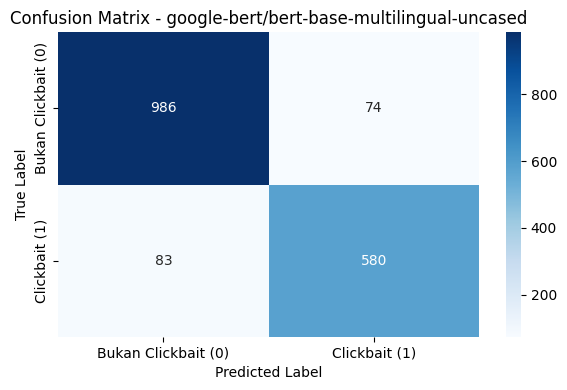

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Bukan Clickbait (0)", "Clickbait (1)"],
            yticklabels=["Bukan Clickbait (0)", "Clickbait (1)"])
plt.title("Confusion Matrix - google-bert/bert-base-multilingual-uncased")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_generate.png", dpi=300)
print("Confusion matrix disimpan di 'confusion_matrix_generate.png'")
plt.show()

In [20]:
df_predictions

,judul,prediksi,probabilitas,waktu,ram,vram,label_asli
0,gunung sampah di cilebut bogor bikin sungai ci...,0,0.049428,0.703033,13.555376,3.971252,0
1,tulis orang orang biasa andrea hirata perjuang...,1,0.827358,0.146973,13.680595,3.973206,0
2,43 penerbangan terganggu asap ratusan penumpan...,0,0.005109,0.167366,13.679207,3.973206,0
3,bicara soal gading marten gisella anastasia me...,1,0.976498,0.148064,13.675968,3.973206,1
4,pelatih leicester tatap laga kontra man united...,0,0.030233,0.150851,13.674082,3.973206,0
...,...,...,...,...,...,...,...
1718,lima warga tewas usai pesta miras di pinggiran...,0,0.036315,0.153497,13.636675,3.973206,0
1719,ledakan hebat di australia hancurkan 100 konta...,0,0.083158,0.146476,13.637424,3.973206,0
1720,bursa transfer liga 1 daftar lengkap perpindah...,0,0.218973,0.166682,13.635500,3.973206,0
1721,greysia apriyani melangkah ke babak kedua chin...,0,0.004422,0.149876,13.633560,3.973206,0
